C:\Users\Karan Dabola\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Karan Dabola\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Karan Dabola\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Karan Dabola\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\Karan Dabola\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.w

Base RMSE/MAE:
     model      rmse       mae
0  UserCF  1.068781  0.810604
1  ItemCF  0.932826  0.726524
2     PMF  2.819049  2.553107 

Similarity impact (cosine, MSD, Pearson):
   similarity  type      rmse       mae
0     cosine  user  1.068141  0.806797
1     cosine  item  0.934895  0.728283
2        msd  user  0.918518  0.716039
3        msd  item  0.927747  0.724392
4    pearson  user  2.218977  1.756276
5    pearson  item  0.929174  0.725975 

Neighbor results:
    mode   k      rmse       mae
0  user   5  1.091779  0.838696
1  item   5  0.930545  0.724301
2  user  10  1.079357  0.825929
3  item  10  0.930384  0.727134
4  user  20  1.094769  0.835707
5  item  20  0.933343  0.727853
6  user  40  1.071140  0.811356
7  item  40  0.930099  0.727703
8  user  60  1.044486  0.779070
9  item  60  0.936793  0.731268 



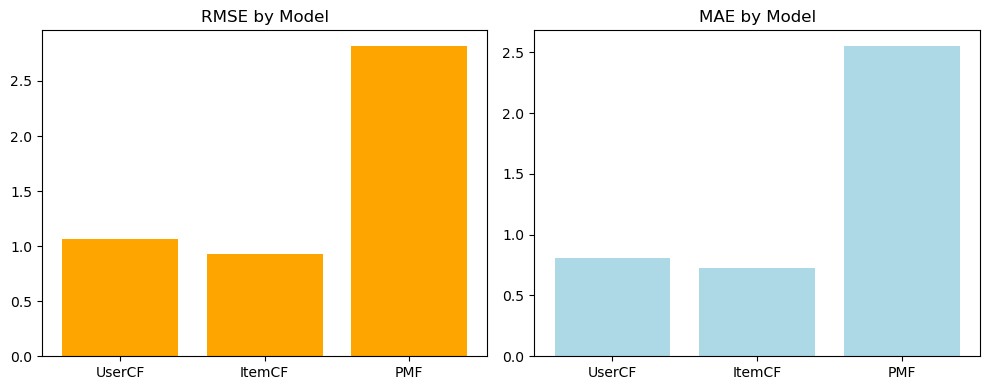

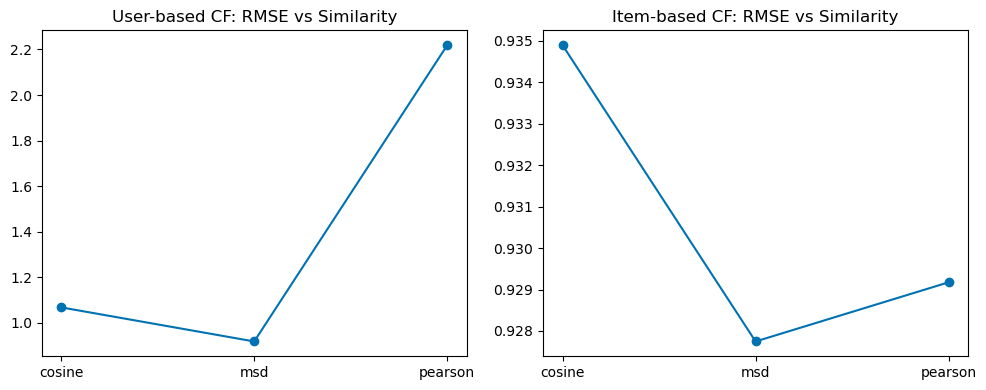

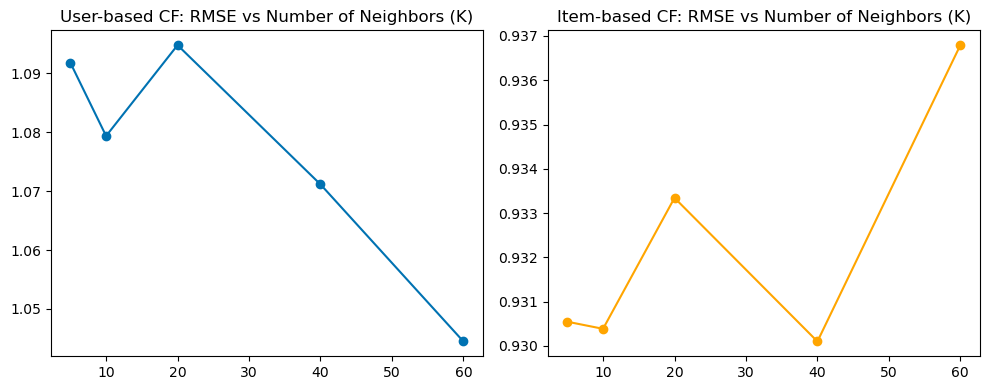

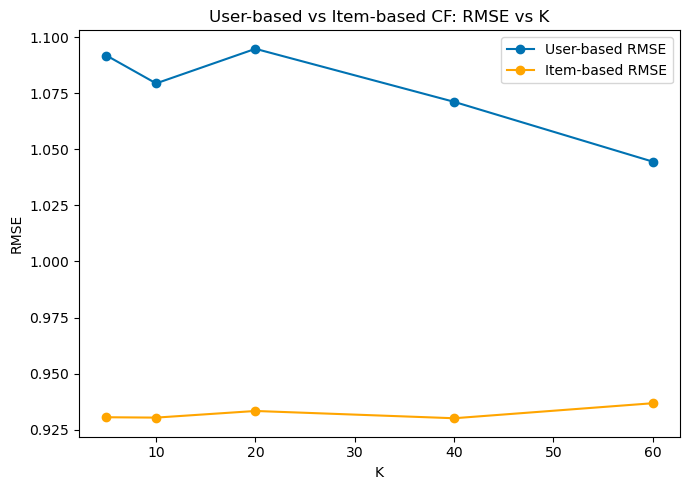

Best overall model (RMSE): ItemCF
Best similarity for UserCF: msd, ItemCF: msd
Best K for UserCF=60 (RMSE=1.0445), ItemCF=40 (RMSE=0.9301)


In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

# === Load and subset data ===
ratings = pd.read_csv(r'D:/datasets/data_mining/datasets_movie/ratings_small.csv')
user_subset = ratings.userId.unique()[:200]
item_subset = ratings.movieId.unique()[:300]
ratings = ratings[ratings.userId.isin(user_subset) & ratings.movieId.isin(item_subset)]

users = ratings.userId.unique(); items = ratings.movieId.unique()
u_map = {u:i for i,u in enumerate(users)}; i_map = {m:j for j,m in enumerate(items)}
R = np.zeros((len(users), len(items)))
for _, r in ratings.iterrows(): R[u_map[r.userId], i_map[r.movieId]] = r.rating

# === Core evaluator ===
def evaluate_model(R, mode="user", metric="cosine", k_neighbors=40, folds=5):
    idx = np.array(np.where(R > 0)).T
    np.random.shuffle(idx)
    fold_sizes = np.full(folds, len(idx)//folds, dtype=int)
    fold_sizes[:len(idx)%folds] += 1
    start = 0; rmses=[]; maes=[]
    for size in fold_sizes:
        test_idx = idx[start:start+size]; start += size
        Rtrain = R.copy(); Rtest = np.zeros_like(R)
        for u,i in test_idx: Rtest[u,i]=Rtrain[u,i]; Rtrain[u,i]=0
        mask_train = Rtrain>0
        mean_user = np.divide(Rtrain.sum(1),(mask_train).sum(1),out=np.zeros(Rtrain.shape[0]),where=(mask_train).sum(1)!=0)
        R_fill = np.where(mask_train, Rtrain, mean_user[:,None])

        if mode in ("user","item"):
            M = R_fill if mode=="user" else R_fill.T
            if metric=="cosine": S = cosine_similarity(M)
            elif metric=="msd":
                norms=np.sum(M**2,1); G=M@M.T; m=M.shape[1]
                mse=(norms[:,None]+norms[None,:]-2*G)/m; S=1/(1+mse)
            elif metric=="pearson":
                mu=M.mean(1,keepdims=True); X=M-mu
                denom=np.linalg.norm(X,axis=1,keepdims=True); denom[denom==0]=1e-9
                Xn=X/denom; S=Xn@Xn.T
            else: S=cosine_similarity(M)
            nU,nI=R_fill.shape
            if mode=="user":
                P=np.zeros_like(R_fill)
                for u in range(nU):
                    sims=S[u].copy(); sims[u]=0
                    idx_nb=np.argsort(-np.abs(sims))[:min(k_neighbors,nU-1)]
                    w=sims[idx_nb]; denom=np.sum(np.abs(w))
                    if denom==0: continue
                    P[u]=(w[:,None]*R_fill[idx_nb]).sum(0)/denom
            else:
                nI=R_fill.shape[1]; P_items=np.zeros((nI,nU))
                for j in range(nI):
                    sims=S[j].copy(); sims[j]=0
                    idx_nb=np.argsort(-np.abs(sims))[:min(k_neighbors,nI-1)]
                    w=sims[idx_nb]; denom=np.sum(np.abs(w))
                    if denom==0: continue
                    P_items[j]=(w[:,None]*R_fill.T[idx_nb]).sum(0)/denom
                P=P_items.T
        else:
            nmf=NMF(n_components=10,init="random",max_iter=100,random_state=42)
            U=nmf.fit_transform(Rtrain); V=nmf.components_; P=U@V

        mask=Rtest>0
        if mask.sum()==0: continue
        y_true=Rtest[mask]; y_pred=P[mask]
        rmses.append(np.sqrt(mean_squared_error(y_true,y_pred)))
        maes.append(mean_absolute_error(y_true,y_pred))
    return float(np.mean(rmses)), float(np.mean(maes))

# === Base models (PMF, UserCF, ItemCF) ===
base=[]
for name,mode in [("UserCF","user"),("ItemCF","item"),("PMF","pmf")]:
    rm,ma=evaluate_model(R,mode=mode,metric="cosine",k_neighbors=40,folds=5)
    base.append({"model":name,"rmse":rm,"mae":ma})
base_df=pd.DataFrame(base)
print("Base RMSE/MAE:\n",base_df,"\n")

# === Similarity metric comparison ===
simres=[]
for sim in ["cosine","msd","pearson"]:
    for mode in ["user","item"]:
        rm,ma=evaluate_model(R,mode=mode,metric=sim,k_neighbors=40,folds=5)
        simres.append({"similarity":sim,"type":mode,"rmse":rm,"mae":ma})
sim_df=pd.DataFrame(simres)
print("Similarity impact (cosine, MSD, Pearson):\n",sim_df,"\n")

# === Neighbor count sweep ===
Ks=[5,10,20,40,60]
kres=[]
for k in Ks:
    for mode in ["user","item"]:
        rm,ma=evaluate_model(R,mode=mode,metric="cosine",k_neighbors=k,folds=5)
        kres.append({"mode":mode,"k":k,"rmse":rm,"mae":ma})
k_df=pd.DataFrame(kres)
print("Neighbor results:\n",k_df,"\n")

# === Visuals ===
plt.style.use("seaborn-v0_8-colorblind")
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].bar(base_df.model,base_df.rmse,color="orange"); ax[0].set_title("RMSE by Model")
ax[1].bar(base_df.model,base_df.mae,color="lightblue"); ax[1].set_title("MAE by Model")
plt.tight_layout(); plt.show()

user_sim=sim_df[sim_df["type"]=="user"]; item_sim=sim_df[sim_df["type"]=="item"]
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].plot(user_sim.similarity,user_sim.rmse,marker="o"); ax[0].set_title("User-based CF: RMSE vs Similarity")
ax[1].plot(item_sim.similarity,item_sim.rmse,marker="o"); ax[1].set_title("Item-based CF: RMSE vs Similarity")
plt.tight_layout(); plt.show()

user_k=k_df[k_df["mode"]=="user"]; item_k=k_df[k_df["mode"]=="item"]
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].plot(user_k.k,user_k.rmse,marker="o"); ax[0].set_title("User-based CF: RMSE vs Number of Neighbors (K)")
ax[1].plot(item_k.k,item_k.rmse,marker="o",color="orange"); ax[1].set_title("Item-based CF: RMSE vs Number of Neighbors (K)")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
plt.plot(user_k.k,user_k.rmse,marker="o",label="User-based RMSE")
plt.plot(item_k.k,item_k.rmse,marker="o",label="Item-based RMSE",color="orange")
plt.title("User-based vs Item-based CF: RMSE vs K"); plt.xlabel("K"); plt.ylabel("RMSE")
plt.legend(); plt.tight_layout(); plt.show()

# === Best parameters summary ===
best_user=user_k.loc[user_k.rmse.idxmin()]
best_item=item_k.loc[item_k.rmse.idxmin()]
print(f"Best overall model (RMSE): {base_df.loc[base_df.rmse.idxmin(),'model']}")
print(f"Best similarity for UserCF: {user_sim.loc[user_sim.rmse.idxmin(),'similarity']}, ItemCF: {item_sim.loc[item_sim.rmse.idxmin(),'similarity']}")
print(f"Best K for UserCF={int(best_user.k)} (RMSE={best_user.rmse:.4f}), ItemCF={int(best_item.k)} (RMSE={best_item.rmse:.4f})")
